In [ ]:
from timeseries_fastai.imports import *
from timeseries_fastai.data import *
from timeseries_fastai.core import *
from timeseries_fastai.models import *

In [ ]:
PATH = get_ucr()

We can Load the supplied Adiac 

In [ ]:
df_train, df_test = load_df_ucr(PATH, 'Adiac')

Loading files from: /home/tc256760/.fastai/data/Univariate_arff/Adiac


In [ ]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att168,att169,att170,att171,att172,att173,att174,att175,att176,target
0,1.598007,1.599439,1.570529,1.550474,1.507371,1.434341,1.368986,1.305294,1.210305,1.116653,...,1.120906,1.217175,1.312530,1.402920,1.481043,1.521012,1.564154,1.570855,1.592890,b'22'
1,1.701146,1.670645,1.618884,1.546805,1.475469,1.391209,1.305882,1.237313,1.153414,1.069690,...,1.012163,1.097360,1.182578,1.266291,1.350571,1.435160,1.519737,1.602518,1.670190,b'28'
2,1.722342,1.695329,1.656946,1.606312,1.511824,1.414148,1.313688,1.213234,1.112978,1.015081,...,1.065598,1.164750,1.263924,1.364303,1.463511,1.547307,1.641809,1.694973,1.708488,b'21'
3,1.726263,1.659836,1.573108,1.496264,1.409070,1.332443,1.245742,1.158882,1.073361,0.987165,...,1.114440,1.199608,1.275380,1.362258,1.448567,1.535131,1.622158,1.707838,1.739027,b'15'
4,1.778976,1.761203,1.703084,1.610572,1.492088,1.368654,1.244761,1.120900,1.010762,0.900168,...,1.165685,1.285657,1.408878,1.507983,1.623643,1.713606,1.766389,1.783633,1.758625,b'2'


In [ ]:
df = stack_train_valid(df_train, df_test)

In [ ]:
x_cols = df.columns[0:-2].to_list()

In [ ]:
dls = TSDataLoaders.from_df(df, x_cols=x_cols, label_col='target', valid_col='valid_col', bs=16)

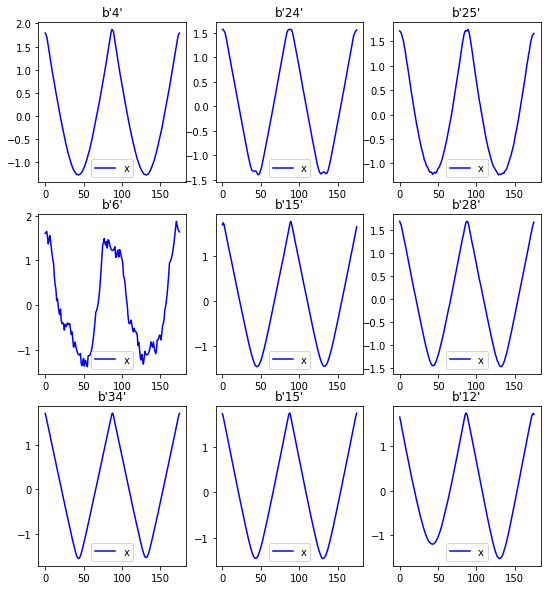

In [ ]:
dls.show_batch()

In [ ]:
resnet = create_inception(1, len(dls.vocab))

In [ ]:
learn = Learner(dls, resnet, metrics=[accuracy])

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.052514,3.651268,0.035806,00:02
1,3.670097,3.663121,0.058824,00:01
2,3.399806,3.457608,0.089514,00:01
3,3.069047,2.641782,0.209719,00:01
4,2.732379,2.412086,0.327366,00:01


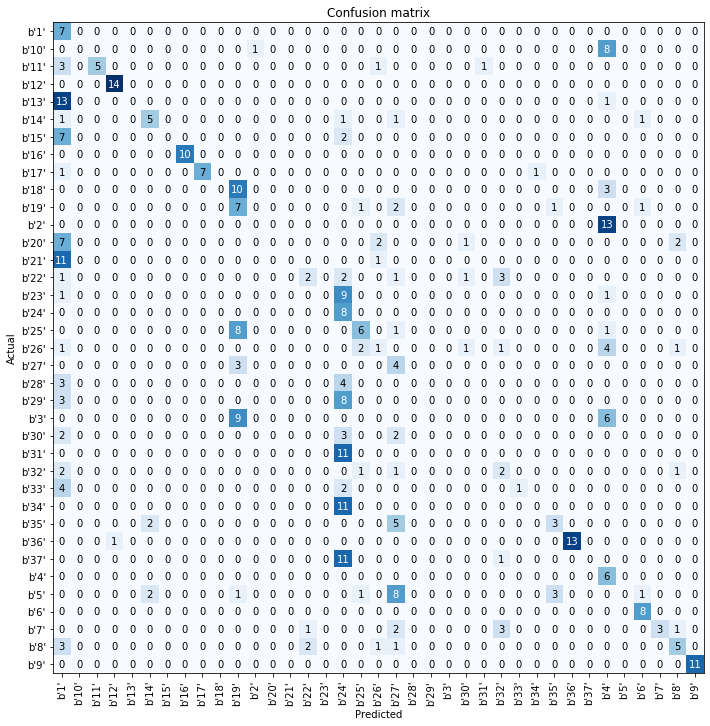

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))